# Exploration of Data and Visualizations of Data

#### This notebook explores the data set that contains latitudes and longitudes, i.e. the data from years 2009-2015, taken from [kaggle](https://www.kaggle.com/code/rafay12/nyc-taxi-fare-data-exploration/notebook). The motivation of using this dataset is that we have the liberty to create as fine or coarse of a meshgrid over NYC as we would like. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

#### Load the data and take a look at what we have -- took me about 3.5 minutes to load in.

In [2]:
df = pd.read_parquet('../data/raw_data/yellow_09-15_data.parquet')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


##### We are not concerned with the 'key', 'fare_amount' columns so we will remove them from the dataframe. At that point, we will also want to drop any values with NaN. As this dataset is so large, dropping these will likely not make a huge difference in predictive output. We will keep the dropoff latitude and longitude data for now as we may use it later on.

In [3]:
df = df.drop(columns=['key', 'fare_amount'])

len_before = len(df)
df = df.dropna()
len_after = len(df)
print(f'Dropped {len_before - len_after} rows with NaN values')


Dropped 376 rows with NaN values


##### Let's actually see how many data points we have

In [4]:
print(len(df))

55433394


##### We likely have values in the dataset where the pickup location is outside of the bounds of NYC. We will drop those, too. These bounds are taken from [Wikipedia](https://en.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City)

In [5]:
lat_min, lat_max = 40.49, 40.92
lon_min, lon_max = -74.27, -73.68

len_before = len(df)
df = df[(df['pickup_latitude'] > lat_min) & (df['pickup_latitude'] < lat_max)]
df = df[(df['pickup_longitude'] > lon_min) & (df['pickup_longitude'] < lon_max)]
len_after = len(df)

print(f"This dropped {len_before - len_after} rows with invalid pickup coordinates")
print(f"This may seem like a lot, but is only {100*(len_before - len_after)/len_before:.4f}% of the data")

This dropped 1151287 rows with invalid pickup coordinates
This may seem like a lot, but is only 2.0769% of the data


##### Maybe we should have done this earlier, but let's check the data types of the data

In [6]:
df.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

##### Let's also confirm that we still have data from 2009 to 2015 as claimed.

In [7]:
print(f"Earliest data: {df['pickup_datetime'].min()}")
print(f"Latest data: {df['pickup_datetime'].max()}")

Earliest data: 2009-01-01 00:00:27 UTC
Latest data: 2015-06-30 23:59:54 UTC


##### Now we can have some fun and make some pretty visualizations of the data!

In [11]:
from PIL import Image
import urllib.request
import ssl

##### First we display a map of NYC (very google maps esque). Independent of our data.

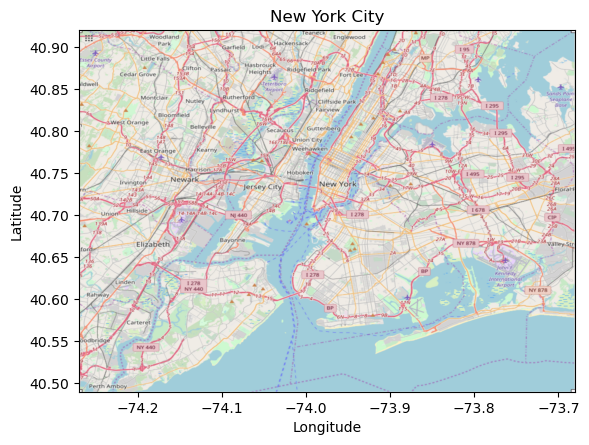

In [14]:
# Create an unverified SSL context
ssl_context = ssl._create_unverified_context()  # generally bad practice

# URL to the map image
url = 'https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png'

# Open the URL without SSL verification
with urllib.request.urlopen(url, context=ssl_context) as response:
    image = Image.open(response)

nyc_map_zoom = np.array(image)

plt.imshow(nyc_map_zoom, zorder=0, extent=[lon_min, lon_max, lat_min, lat_max])
plt.title('New York City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

##### Now let's see what our data looks overlayed on this map.

In [16]:
# This function can be used for other plots later.
def plot_overlay(data, map, s=1, alpha=0.3):
    plt.imshow(map, zorder=0, extent=[lon_min, lon_max, lat_min, lat_max])
    plt.scatter(data['pickup_longitude'], data['pickup_latitude'], s=s, alpha=alpha)
    plt.title('New York City')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

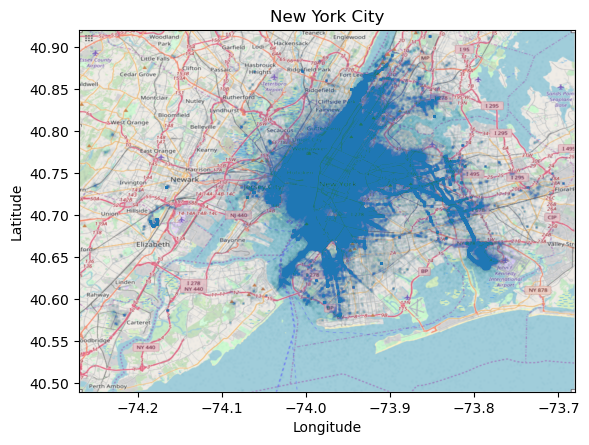

In [19]:
plot_overlay(df, nyc_map_zoom, s=1, alpha=0.01)

As you can see above, even with an alpha value of 0.01, it is a bit difficult to pinpoint exactly where the pickup locations occur. Let's try something else.

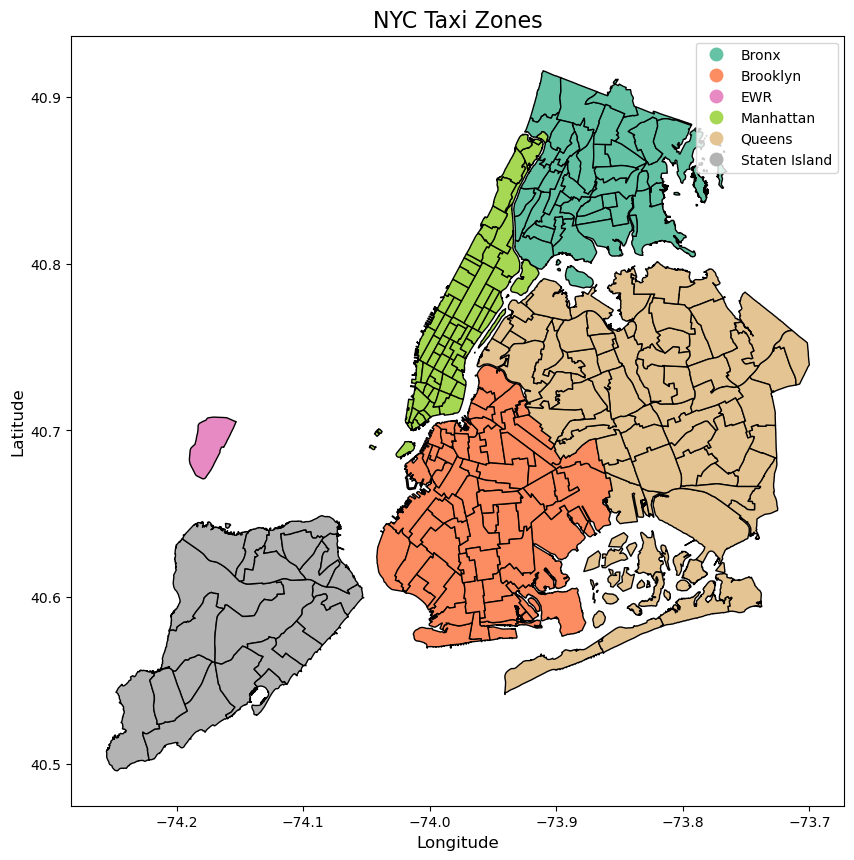

In [31]:
taxi_zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')
taxi_zones = taxi_zones.to_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zones.plot(column='borough', cmap='Set2', legend=True, ax=ax, edgecolor='black')

ax.set_title('NYC Taxi Zones', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()